In [ ]:
import tensorflow as tf
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds

# Load a subset of LFW (e.g., 5000 images)
subset_size = 5000
BUFFER_SIZE = subset_size
BATCH_SIZE = 128

# Load LFW dataset
dataset = tfds.load("lfw", split=f"train[:{subset_size}]", as_supervised=False)

# Preprocess: Resize and normalize to [-1, 1]
def preprocess(example):
    image = example['image']  # shape: (250, 250, 3)
    image = tf.image.resize(image, [64, 64])
    image = tf.cast(image, tf.float32)
    image = (image - 127.5) / 127.5  # Normalize to [-1, 1]
    return image

# Apply preprocessing and prepare batches
train_dataset = dataset.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


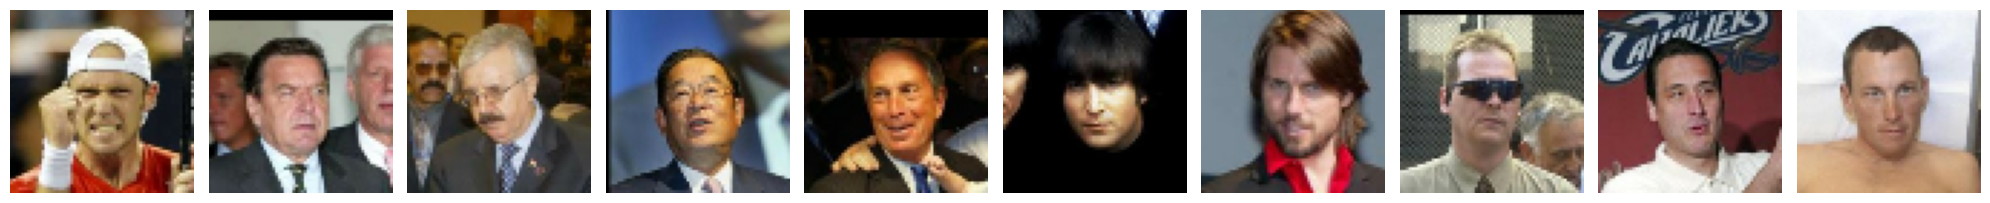

In [ ]:
import matplotlib.pyplot as plt

for image_batch in train_dataset.take(1):
    plt.figure(figsize=(20, 4))  # Increase figure size (width=20, height=4)

    for i in range(10):
        plt.subplot(1, 10, i + 1)
        plt.imshow((image_batch[i].numpy() + 1) / 2)  # Back to [0,1]
        plt.axis('off')

    plt.tight_layout()
    plt.show()


# Generator Model for 64×64×3 Face Generation

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

def make_generator_model():
    model = tf.keras.Sequential()

    # Input: 100-d noise vector
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((8, 8, 256)))  # (8, 8, 256)
    assert model.output_shape == (None, 8, 8, 256)

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    # Output: (16, 16, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    # Output: (32, 32, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same',
                                     use_bias=False, activation='tanh'))
    # Output: (64, 64, 3)
    assert model.output_shape == (None, 64, 64, 3)

    return model


# Image Display Code for RGB Output

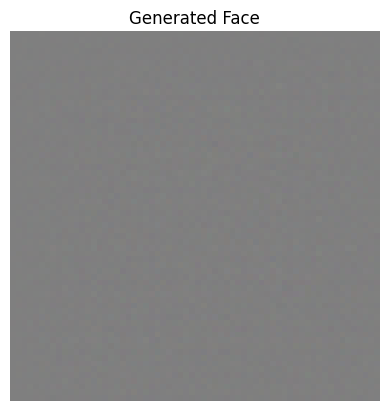

In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf

# Create generator and generate image from random noise
generator = make_generator_model()
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

# Convert from [-1, 1] → [0, 1] for visualization
img = (generated_image[0] + 1) / 2.0

# Plot the image
plt.imshow(img.numpy())
plt.axis('off')
plt.title("Generated Face")
plt.show()



# Discriminator Model for LFW (64×64×3)

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

def make_discriminator_model():
    model = tf.keras.Sequential()

    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                            input_shape=[64, 64, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))  # No activation (used with logits in loss)

    return model

# 1. Initialize Discriminator
discriminator = make_discriminator_model()

# 2. Generate image from noise using your trained (or untrained) generator
noise = tf.random.normal([1, 100])  # shape: (1, 100)
generated_image = generator(noise, training=False)  # shape: (1, 64, 64, 3)

# 3. Feed generated image into discriminator
decision = discriminator(generated_image, training=False)  # shape: (1, 1)

# 4. Print raw decision and real-face probability (optional)
print("Logit output:", decision.numpy()[0][0])

# Optional: apply sigmoid to interpret as probability
probability = tf.sigmoid(decision)
print("Discriminator confidence (real):", probability.numpy()[0][0])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Logit output: 0.00043228694
Discriminator confidence (real): 0.50010806


In [ ]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

# Discriminator loss

In [ ]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

# Generator loss

In [ ]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

# Save checkpoints

In [ ]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

# Training loop

In [ ]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [ ]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [ ]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

# Generate & Save image

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def generate_and_save_images(model, epoch, test_input):
    # Generate fake images (in inference mode)
    predictions = model(test_input, training=False)

    # Create figure for displaying images
    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        img = (predictions[i].numpy() + 1.0) / 2.0  # Scale [-1, 1] to [0, 1]
        plt.imshow(img)
        plt.axis('off')

    # Save and display
    plt.savefig(f'image_at_epoch_{epoch:04d}.png')
    plt.show()


# Train the model

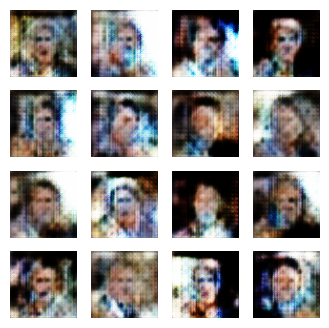

In [ ]:
train(train_dataset, EPOCHS)

# Restore the latest checkpoint.

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

# Create a GIF

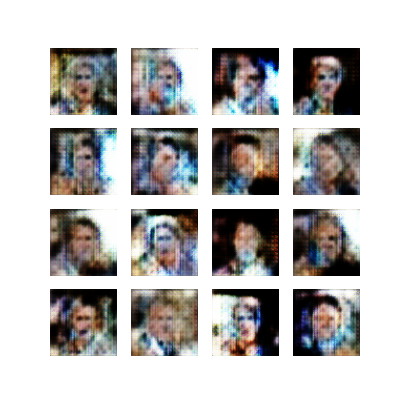

In [ ]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

display_image(EPOCHS)